## **Basic RALPH Implementation**


In [1]:
%pylab inline
import cv2
from ipywidgets import interact
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


## **Load Image**

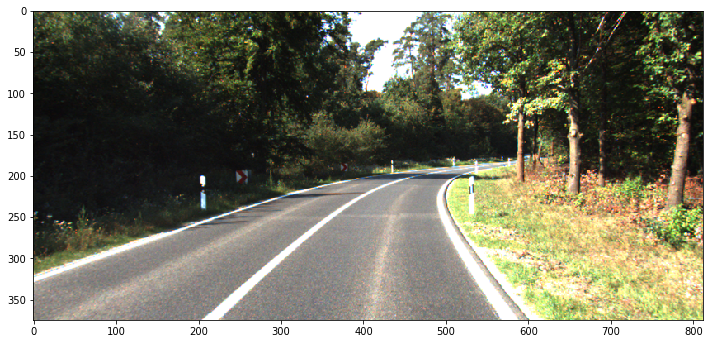

In [3]:
frame_num = 37
im = imread('../data_sample/' + str(frame_num).zfill(10) + '.png')

lateral_crop = 200

#Do a little bit of recentering by cropping, Kitti images were captured from a non-center-mounted camera.
im = im[:, lateral_crop:-(lateral_crop+30), :]

im = (im*255).astype('uint8')
fig = figure(0, (12,12))
imshow(im)
grid('off')

## **Draw Trapezoid**

In [4]:
def draw_trap(x1 = 315, y1 = 215, x2=130, y2=300):
    y3 = y1
    y4 = y2
    x3 = im.shape[1]-x1
    x4 = x3+(x1-x2)

    fig = figure(0, (12,12))
    imshow(im)
    plot((x1, x2), (y1, y2), c= 'm', linewidth = 3)
    plot((x2, x4), (y2, y4), c= 'm', linewidth = 3)
    plot((x3, x4), (y3, y4), c= 'm', linewidth = 3)
    plot((x3, x1), (y3, y1), c= 'm', linewidth = 3)

- Tune Trapezoid cornere using interact module
- Generally the best way to do this is to find a nice straight portion of road and try to make the left and right sides of the trapezoid parallel to the lane markers on the road. 

In [5]:
interact(draw_trap, x1 = (0, 800), y1 = (0, 800), x2 = (0, 800), y2 = (0, 800))

interactive(children=(IntSlider(value=315, description='x1', max=800), IntSlider(value=215, description='y1', max=800), IntSlider(value=130, description='x2', max=800), IntSlider(value=300, description='y2', max=800), Output()), _dom_classes=('widget-interact',))

<function __main__.draw_trap>

(-0.5, 811.5, 374.5, -0.5)

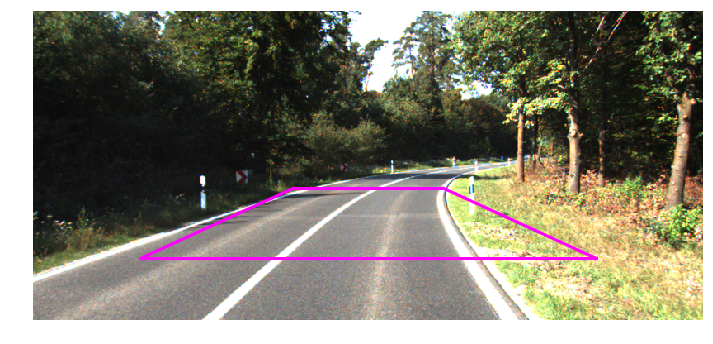

In [6]:
#Final trapezoid values
x1 = 315 
y1 = 215 
x2 = 130
y2 = 300
x3 = im.shape[1]-x1 

y3 = y1
y4 = y2
x4 = x3+(x1-x2)

fig = figure(0, (12,12))
imshow(im)
plot((x1, x2), (y1, y2), c = [1, 0, 1], linewidth = 3)
plot((x2, x4), (y2, y4), c = [1, 0, 1], linewidth = 3)
plot((x3, x4), (y3, y4), c = [1, 0, 1], linewidth = 3)
plot((x3, x1), (y3, y1), c = [1, 0, 1], linewidth = 3)
grid(0)
axis('off')

## ** Sample and Warp Pixels in Trapezoid Region**

- We need 4 new corners to warp the existing corners to, this is a bit arbitrary:

In [7]:
x1_final = 1024
x2_final = x1_final
y1_final = 0
y2_final = 960

x3_final = 2048
x4_final = 2048
y3_final = y1_final
y4_final = y2_final

## **Compute Homography**

- For more information on homographies, I highly recommend chapter 15 of [Prince Computer Vision](http://www.computervisionmodels.com/).

In [8]:
src_points = np.array([[x1, y1],
                       [x2, y2],
                       [x3, y3],
                       [x4, y4]])

dst_points = np.array([[x1_final, y1_final],
                       [x2_final, y2_final],
                       [x3_final, y3_final],
                       [x4_final, y4_final]])

H, _ = cv2.findHomography(src_points, dst_points)

## ** Crop Trapezoidal Region**

In [9]:
#Number of image rows in trapezoidal regiond
num_rows = y2-y1

#Right and left boundaries of trapezoidal region
left_edge = np.linspace(x1, x2, num_rows).round().astype('int')
right_edge = np.linspace(x3, x4, num_rows).round().astype('int')

im_cropped = np.zeros_like(im)

#There's faster ways to do this, but this will work for now:
for i, y in enumerate(range(y1, y2)):
    for j in range(3):
        im_cropped[y, left_edge[i]:right_edge[i], j] = im[y, left_edge[i]:right_edge[i], j]


## **Warp Cropped Region to Overhead View**

In [10]:
warped = cv2.warpPerspective(im_cropped, H, dsize = (3072, 960))

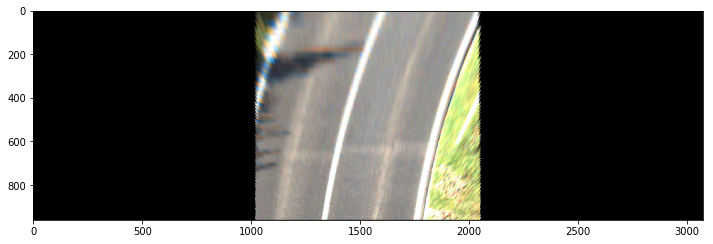

In [11]:
fig = figure(0, (12,6))
imshow(warped)

## **Downsample and convert to grayscale**

In [12]:
# Dean also downsampled his warped image, we'll use a factor of 16, to make our final overhead images 60x64
downsampling_factor = 16

new_size = tuple((np.array([warped.shape[1], warped.shape[0]])/downsampling_factor).astype('int'))
warped_small = cv2.resize(warped, new_size)
warped_small_gray = cv2.cvtColor(warped_small, cv2.COLOR_BGR2GRAY)

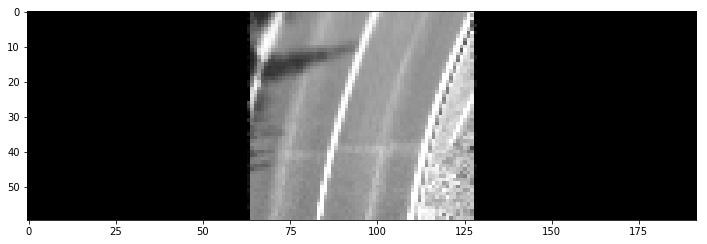

In [13]:
fig = figure(0, (12,6))
imshow(warped_small_gray, cmap = 'gray')

## **Create Special upsampled image with alpha channel for export**

In [14]:
output_image = np.zeros((warped.shape[0], warped.shape[1], 4), dtype = 'uint8')

mask = np.zeros_like(warped[:,:,0])
one_third = int(round(mask.shape[1]/3))
mask[:, one_third:-one_third] = 1

output_image[:,:,3] = mask*255 
output_gray = np.copy(output_image)

##Downsampling
new_size = tuple((np.array([warped.shape[1], warped.shape[0]])/downsampling_factor).astype('int'))

warped_small = cv2.resize(warped, new_size)
warped_upsampled = cv2.resize(warped_small, (warped.shape[1], warped.shape[0]), interpolation = cv2.INTER_NEAREST)
output_image[:,:,:3] = warped_upsampled

#Shift to grayscale
warped_gray = cv2.cvtColor(warped_upsampled, cv2.COLOR_BGR2GRAY)
output_gray[:,:,0] = warped_gray
output_gray[:,:,1] = warped_gray
output_gray[:,:,2] = warped_gray

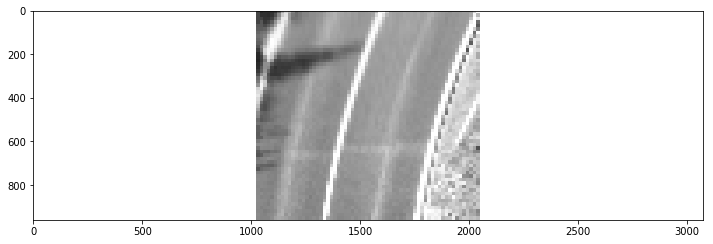

In [15]:
fig = figure(0, (12,6))
imshow(output_gray)

In [16]:
output_gray.shape

(960, 3072, 4)

## **Unroll Image**

In [17]:
#Distance from top of image to car, educated guess: 
k = 100

In [18]:
def unroll_image(warped_small_gray, direction, R, k, x_padding = 64):
    '''
    Unroll warped_small_gray image. 
    direction = left or right
    R = radius of circle
    k = distance from top of image to car
    x_padding = amount of zeros padding on the left and right of warped_small_gray
    '''
    
    W = warped_small_gray.shape[1] #Image width
    H = warped_small_gray.shape[0] #Image heigth

    if direction == 'left':
        h = W/2 - R
    elif direction == 'right':
        h = W/2 + R
    else:
        print('direction not implemented')

    shifts = np.zeros(warped_small_gray.shape[0])
    for y in range(len(shifts)):
        if direction == 'right':
            shifts[y] = np.sqrt(R**2 - (y-k)**2) - R
        elif direction == 'left':
            shifts[y] = R - np.sqrt(R**2 - (y-k)**2)

    shifts = shifts.round().astype('int')

    shifted_image = np.zeros_like(warped_small_gray)
    mask_small = np.zeros_like(warped_small_gray)

    for y in range(shifted_image.shape[0]):
        shifted_image[y, x_padding+shifts[y]:-(x_padding-shifts[y])] = warped_small_gray[y, x_padding:-x_padding]
        mask_small[y, x_padding+shifts[y]:-(x_padding-shifts[y])] = 255
        
    return shifted_image, mask_small

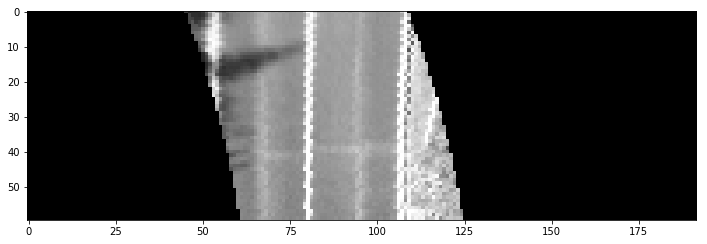

In [19]:
#Compute an example unrolling
shifted_image, mask_small = unroll_image(warped_small_gray, 
                                         direction = 'right', 
                                         R = 275, 
                                         k = k, 
                                         x_padding = 64)

fig = figure(0, (12,6))
imshow(shifted_image, cmap = 'gray')

## ** Compute Scanline**

In [20]:
def compute_scanline(shifted_image, mask_small, same_padding_columns = 5):
    '''
    Compute scanline and top 5 largest adjacent differences, and compute score
    same_padding_columns = number of columns to pad on each side of mask.
    '''

    overhead_nan_image = np.copy(shifted_image).astype('float32')
    overhead_nan_image[np.logical_not(mask_small)] = np.NaN

    #Add padding
    for i in range(overhead_nan_image.shape[0]):
        for j in range(overhead_nan_image.shape[1]-1):
            if np.isnan(overhead_nan_image[i, j]) and not np.isnan(overhead_nan_image[i, j+1]):
                overhead_nan_image[i, j-same_padding_columns:j+1] = overhead_nan_image[i, j+1]
                break;

        for j in range(overhead_nan_image.shape[1]-1):       
            if not np.isnan(overhead_nan_image[i, j]) and np.isnan(overhead_nan_image[i, j+1]):
                overhead_nan_image[i, j:j+same_padding_columns] = overhead_nan_image[i, j]
                break;
                
    scanline = np.sum(overhead_nan_image, axis = 0)
                
    scanline_trimmed = scanline[~np.isnan(scanline)]

    d = np.diff(scanline_trimmed.astype('float'))
    sI = argsort(abs(d)) 
    top_5 = d[sI[-5:]]
    score = sum(abs(top_5))

    sI_shifted = np.where(~np.isnan(scanline))[0][sI]         
    
    return scanline, sI_shifted, score

In [21]:
scanline, sI_shifted, score = compute_scanline(shifted_image, mask_small, same_padding_columns = 5)

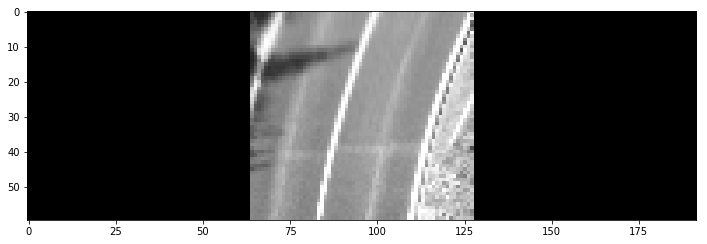

In [22]:
#Compute an example unrolling
shifted_image, mask_small = unroll_image(warped_small_gray, 
                                         direction = 'right', 
                                         R = 1e5, 
                                         k = k, 
                                         x_padding = 64)

fig = figure(0, (12,6))
imshow(shifted_image, cmap = 'gray')

In [23]:
scanline, sI_shifted, score = compute_scanline(shifted_image, mask_small, same_padding_columns = 5)

(0, 16000)

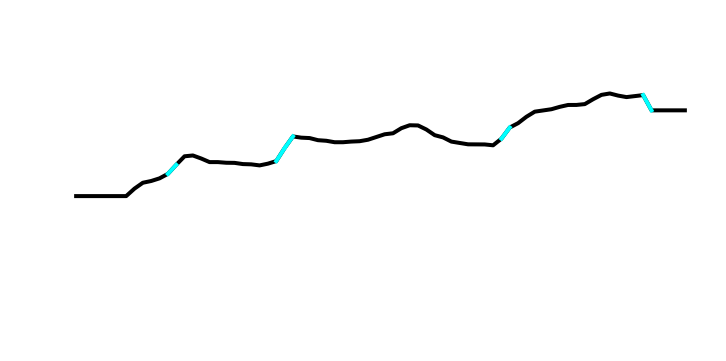

In [24]:
clf()
fig = figure(0, (12,6))
plot(scanline, linewidth = 4.0, color = 'k')

for top_index in sI_shifted[-5:]:
    plot((top_index, top_index + 1) , 
         (scanline[top_index], scanline[top_index+1]), c = [0, 1, 1], linewidth= 4)

axis('off')
ylim(0, 16000)
#savefig('exports/p_34/scanlines/p_34_scanline_' + str(i).zfill(3) + '.png', transparent = True, dpi = 100)

## **Work Across Range of Curvature Hypotheses**

In [25]:
def one_over_mapping(start, end, numpoints):
    start_inverse = 1.0/start
    end_inverse = 1.0/end
    
    inverse_points = np.linspace(start_inverse, end_inverse, numpoints)
    return 1.0/inverse_points

In [26]:
# For the sake of simplicity, assume 1 m = 1 pixel 

def find_optimal_unwrapping(warped_small_gray, steps = 512, min_radius = 150, max_radius = 1e4, same_padding_columns = 5):
    
    # Curvature Hypotheses
    radii = np.concatenate((one_over_mapping(min_radius, max_radius, steps), [1e6], one_over_mapping(max_radius, min_radius, steps)))
    directions = ['right']*(steps+1)
    directions.extend(['left']*steps)

    scores = []

    for i, R in enumerate(tqdm(radii)):
        direction = directions[i]

        shifted_image, mask_small = unroll_image(warped_small_gray, 
                                                 direction = direction, 
                                                 R = R, 
                                                 k = k, 
                                                 x_padding = 64)

        scanline, sI_shifted, score = compute_scanline(shifted_image, mask_small, same_padding_columns)
        scores.append(score)
        
    scores = np.array(scores)
    winning_index = np.argmax(scores)
    
    R = radii[winning_index]
    direction = directions[winning_index]
    
    shifted_image, mask_small = unroll_image(warped_small_gray, 
                                             direction = direction, 
                                             R = R, 
                                             k = k, 
                                             x_padding = 64)

    scanline, sI_shifted, score = compute_scanline(shifted_image, mask_small, same_padding_columns)
    
    return shifted_image, mask_small, scanline, sI_shifted, scores

In [27]:
shifted_image, mask_small, scanline, sI_shifted, scores = find_optimal_unwrapping(warped_small_gray, 
                                                                                  steps = 16, 
                                                                                  min_radius = 150, 
                                                                                  max_radius = 1e4)

100%|██████████| 33/33 [00:03<00:00,  7.97it/s]


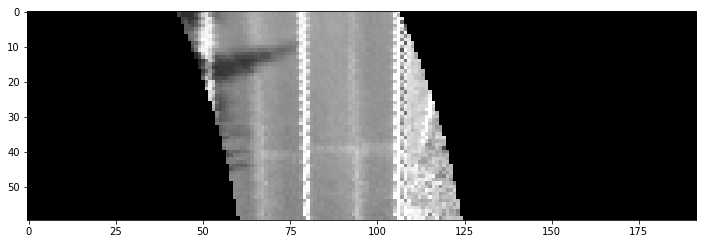

In [28]:
fig = figure(0, (12,6))
imshow(shifted_image, cmap = 'gray')

(0, 16000)

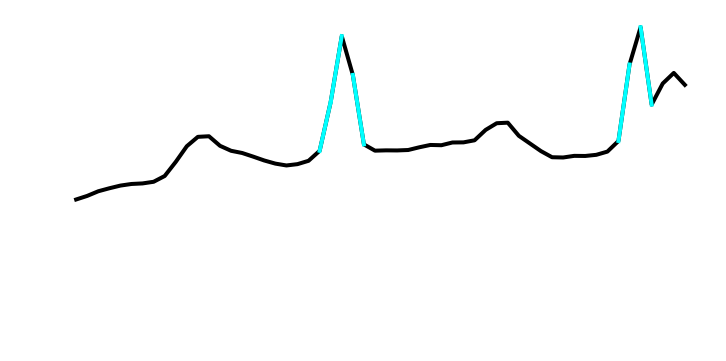

In [29]:
clf()
fig = figure(0, (12,6))
plot(scanline, linewidth = 4.0, color = 'k')

for top_index in sI_shifted[-5:]:
    plot((top_index, top_index + 1) , 
         (scanline[top_index], scanline[top_index+1]), c = [0, 1, 1], linewidth= 4)

axis('off')
ylim(0, 16000)
#savefig('exports/p_34/scanlines/p_34_scanline_' + str(i).zfill(3) + '.png', transparent = True, dpi = 100)

(-0.007, 0.007)

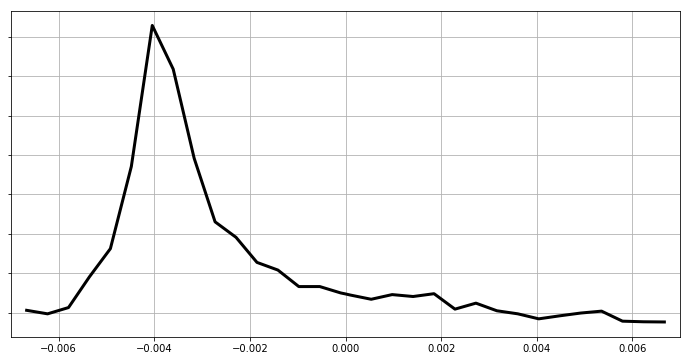

In [30]:
steps = 16
min_radius = 150
max_radius = 1e4
radii = np.concatenate((one_over_mapping(min_radius, max_radius, steps), [1e6], one_over_mapping(max_radius, min_radius, steps)))
directions = ['right']*(steps+1)
directions.extend(['left']*steps)

clf()
fig = figure(0, (12,6))
ax = fig.add_subplot(111)
abscissa = 1/radii 
abscissa[np.array(directions)=='right'] = abscissa[np.array(directions)=='right']*-1
plot(abscissa[:len(scores)], scores, linewidth = 3, c = 'k')

grid(1)
# ax.tick_params(labelbottom=False)  
ax.tick_params(labelleft=False)  
xlim([-0.007, 0.007])